In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import torch.nn.functional as F
import tqdm
from collections import deque

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation function
        x = self.fc2(x)
        return x


In [3]:
class DQNAgent:
    def __init__(self, input_dim, output_dim, lr=1e-3, gamma=0.75, epsilon=1.0, epsilon_min=0.01, epsilon_decay=1e-2, batch_size=64, replay_buffer_size=500):
        """Sets up all the agent parameters"""
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.model = DQN(input_dim, output_dim)
        self.target_model = DQN(input_dim, output_dim)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        """Select actions using an epsilon greedy policy where epsilon decreases over episodes"""
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.output_dim)
        else:
            with torch.no_grad():
                q_values = self.model(torch.tensor(state).float())
                return torch.argmax(q_values).item()

    def replay(self):
        """Replay a batch of previous experiences to prevent catastrophic forgetting"""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.model(states).gather(1, actions)
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values.unsqueeze(1)

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_model(self):
        """Updates the target model with weights of the online model"""
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        """Decays the epsilon which controls the policy"""
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)

    def remember(self, state, action, reward, next_state, done):
        """stores a particular (state, action, reward, next_state) pair in replay memory"""
        self.replay_buffer.append((state, action, reward, next_state, done))

In [4]:
def train_agent(env_name='CartPole-v1', episodes=5500):
    env = gym.make(env_name)
    agent = DQNAgent(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0

        while not done:
            # take an action, store in replay memory, replay a mini-batch from memory
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.replay()
        
        if episode % 10 == 0:
            # update the target model with weights of online model
            agent.update_target_model()
            agent.decay_epsilon()

        rewards_per_episode.append(total_reward)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent, rewards_per_episode

In [5]:
agent, rewards = train_agent()
print("Average reward:", np.mean(rewards))

Episode: 1, Total Reward: 29.0, Epsilon: 0.99
Episode: 2, Total Reward: 11.0, Epsilon: 0.99
Episode: 3, Total Reward: 33.0, Epsilon: 0.99
Episode: 4, Total Reward: 16.0, Epsilon: 0.99
Episode: 5, Total Reward: 14.0, Epsilon: 0.99
Episode: 6, Total Reward: 15.0, Epsilon: 0.99
Episode: 7, Total Reward: 21.0, Epsilon: 0.99
Episode: 8, Total Reward: 36.0, Epsilon: 0.99


/tmp/ipykernel_272313/2955121653.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  states = torch.tensor(states, dtype=torch.float32)


Episode: 9, Total Reward: 12.0, Epsilon: 0.99
Episode: 10, Total Reward: 47.0, Epsilon: 0.99
Episode: 11, Total Reward: 15.0, Epsilon: 0.98
Episode: 12, Total Reward: 18.0, Epsilon: 0.98
Episode: 13, Total Reward: 16.0, Epsilon: 0.98
Episode: 14, Total Reward: 20.0, Epsilon: 0.98
Episode: 15, Total Reward: 16.0, Epsilon: 0.98
Episode: 16, Total Reward: 23.0, Epsilon: 0.98
Episode: 17, Total Reward: 14.0, Epsilon: 0.98
Episode: 18, Total Reward: 13.0, Epsilon: 0.98
Episode: 19, Total Reward: 19.0, Epsilon: 0.98
Episode: 20, Total Reward: 11.0, Epsilon: 0.98
Episode: 21, Total Reward: 21.0, Epsilon: 0.97
Episode: 22, Total Reward: 38.0, Epsilon: 0.97
Episode: 23, Total Reward: 25.0, Epsilon: 0.97
Episode: 24, Total Reward: 10.0, Epsilon: 0.97
Episode: 25, Total Reward: 14.0, Epsilon: 0.97
Episode: 26, Total Reward: 11.0, Epsilon: 0.97
Episode: 27, Total Reward: 16.0, Epsilon: 0.97
Episode: 28, Total Reward: 30.0, Epsilon: 0.97
Episode: 29, Total Reward: 15.0, Epsilon: 0.97
Episode: 30, T

In [33]:
from tqdm import tqdm
from time import sleep

# Create the environment
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Create a wrapper to record videos
env = gym.wrappers.RecordVideo(env, "record_dir")

# Run the episodes
for i in tqdm(range(1)):
    obs, done, rew = env.reset()[0], False, 0
    while not done:
        action = agent.select_action(obs)  # Corrected method name
        obs, reward, done, _, _ = env.step(action)
        rew += reward
        sleep(0.01)

    print("Episode: {}, Reward: {}".format(i, rew))

# Close the environment
env.close()


  0%|          | 0/1 [00:02<?, ?it/s]

Moviepy - Building video /home/girikk/CODE/record_dir/rl-video-episode-0.mp4.
Moviepy - Writing video /home/girikk/CODE/record_dir/rl-video-episode-0.mp4



100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

Moviepy - Done !
Moviepy - video ready /home/girikk/CODE/record_dir/rl-video-episode-0.mp4
Episode: 0, Reward: 167.0


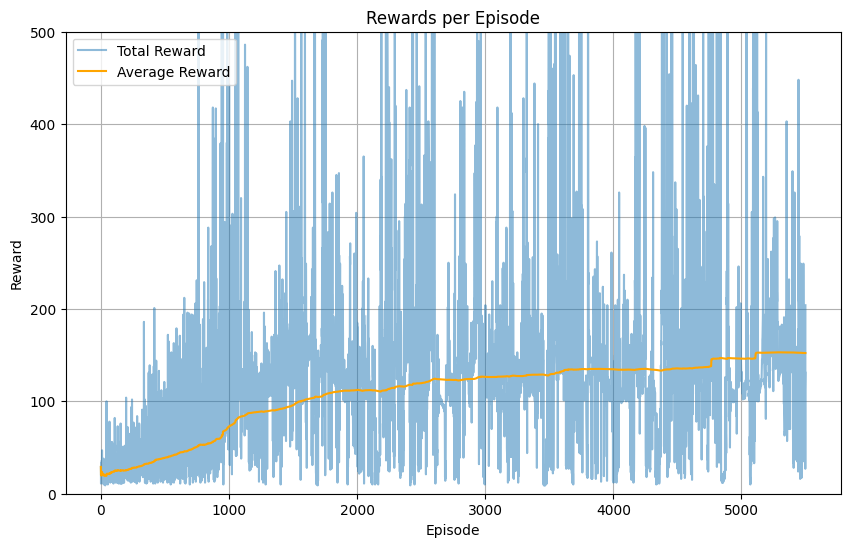

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def plot_rewards(rewards):
    avg_rewards = [np.mean(rewards[:i+1]) for i in range(len(rewards))]
    
    plt.figure(figsize=(10, 6))
    
    # Plot total reward
    plt.plot(rewards, label='Total Reward', alpha=0.5)
    
    # Plot average reward
    plt.plot(avg_rewards, label='Average Reward', color='orange')
    
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.legend()
    plt.grid(True)
    plt.ylim([0, 500])
    
    plt.show()

# Example usage:
# plot_rewards(rewards)


plot_rewards(rewards)

### There is large variance in the rewards earned per episode. This indicates that the learning process is instable. 